In [2]:
import pandas as pd
import numpy as np
import requests
import json
import re

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

In [7]:
import torch
torch.set_num_threads(24)

In [396]:
import json

filename = '/dlabdata1/lugeon/english_words.txt'

english_words = {}
with open(filename) as fh:
    for line in fh:
        word = line.strip().split()[0]
        english_words[word] = None

In [247]:
df = pd.read_csv('/dlabdata1/lugeon/websites_dmoz_multi.gz', compression='gzip')
df.drop('Unnamed: 0', axis=1, inplace=True)
df

,uid,url,lang,lang_id,cat0
0,184,www.delphipraxis.net,Deutsch,de,Computers
1,263,www.central-it.de,Deutsch,de,Computers
2,731,www.aus-wandern.de,Deutsch,de,Computers
3,1072,blog.cvjm-nuernberg.de,Deutsch,de,Computers
4,1101,www.ges-training.de,Deutsch,de,Computers
...,...,...,...,...,...
1025176,2488203,www.stompin-ground.com,English,en,Arts
1025177,2488226,www.quarrypark.co.uk,English,en,Sports
1025178,2488230,www.sugarcreekwines.com,English,en,Recreation
1025179,2488233,www.aera.net,English,en,Reference


In [248]:
def clean_url(url):
    url = re.sub(r"www.|http://|https://|-|_", '', url)
    return url.split('.')[0]

In [249]:
df['clean_url'] = df.apply(lambda x: clean_url(x.url), axis=1)

## English urls only

In [250]:
df_en = df_en[df_en.lang_id == 'en']

In [251]:
df_en.cat0.value_counts()

Business      148144
Society        82079
Arts           66721
Shopping       54062
Recreation     46095
Computers      45194
Sports         34890
Science        28138
Health         24218
Reference      21663
Games          10246
Home            6952
News            3696
Name: cat0, dtype: int64

In [402]:
df_red = df_en.groupby('cat0').sample(100, random_state=42)

In [12]:
def compute_ngram(s, n):
    return [s[i:i+n] for i in range(0, len(s)-n+1)]

def concat_ngrams(s, min_n=3, max_n=7):
    l = []
    for n in range(min_n, max_n+1):
        l += compute_ngram(s, n)
    return list(set(l))

In [13]:
df_red['clean_url'] = df_red.apply(lambda row: clean_url(row.url), axis=1)
df_red['ngrams'] = df_red.apply(lambda row: concat_ngrams(row.clean_url, min_n=3, max_n=len(row.clean_url)), axis=1)

NameError: name 'df_red' is not defined

In [406]:
df_red.head(1)

,uid,url,lang,lang_id,cat0,clean_url,ngrams
673989,965931,www.donniemunro.co.uk,English,en,Arts,donniemunro,"[nniemun, munr, iemu, nie, munro, donni, don, ..."


In [6]:
xlmr = SentenceTransformer('xlm-r-distilroberta-base-paraphrase-v1')
tokenizer = xlmr.tokenizer
ndim = 768

### Only taking ngrams as english words

In [408]:
def get_word_embedding_en(word):
    
    # if not an english word
    if word not in english_words:
        return None
    
    # if english word and embedding computed
    if english_words[word] is None:
        emb = xlmr.encode(word)
        english_words[word] = emb
        return emb
    
    # if english word, but embedding not yet computed
    else:
        return words[word]


In [409]:
def get_url_embedding_en(url_ngrams):
    acc = np.zeros(ndim)
    counter = 0
    for gram in url_ngrams:
        emb = get_word_embedding_en(gram)
        if emb is not None:
            acc += emb
            counter += 1
            
    if counter == 0:
        return None
    else:
        return acc / counter
    

In [410]:
df_red['url_emb'] = df_red.apply(lambda row: get_url_embedding_en(row.ngrams), axis=1)

In [411]:
df_valid = df_red[df_red.url_emb.notnull()]
df_valid.reset_index(inplace=True, drop=True)
print('There is {:.2f}% of urls with english words'.format(df_valid.shape[0] / df_red.shape[0]))

There is 0.87% of urls with english words


In [412]:
df_valid.head(1)

,uid,url,lang,lang_id,cat0,clean_url,ngrams,url_emb
0,965931,www.donniemunro.co.uk,English,en,Arts,donniemunro,"[nniemun, munr, iemu, nie, munro, donni, don, ...","[0.09830150008201599, -0.11457174830138683, 0...."


In [182]:
x = np.concatenate(df_valid.url_emb.to_numpy()).ravel()
x = x.reshape(-1, ndim)
x.shape

(5734, 768)

In [83]:
tsne = TSNE(n_components=2)
x_tsne = tsne.fit_transform(x)

NameError: name 'x' is not defined

<ipython-input-199-d5be2cee2600>:25: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], [])
<ipython-input-199-d5be2cee2600>:26: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_yticks([], [])


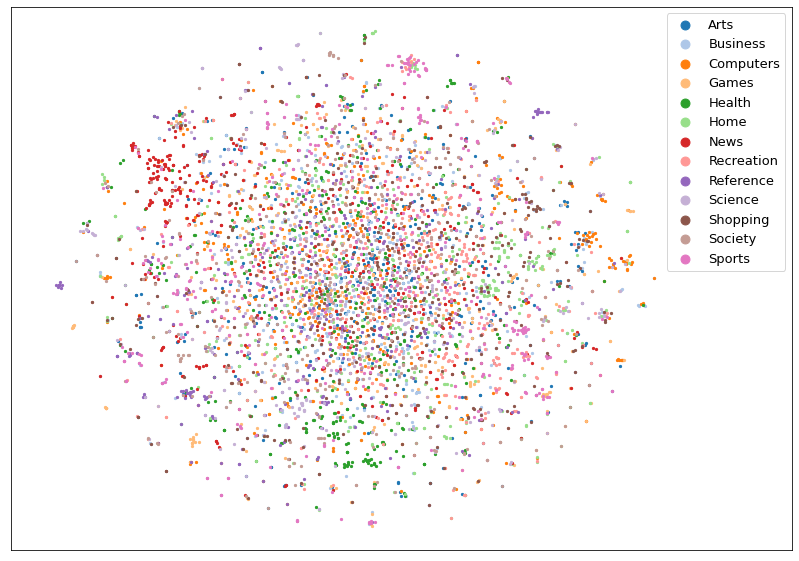

In [199]:
categories = df_valid.cat0.unique()

colormap = plt.get_cmap('tab20')

opacity = 1
marker_size = 5
marker = 'o'

fig, ax = plt.subplots(figsize=(14, 10))

n = 0
ncat = len(categories)

for cat in categories:
    ix = df_valid[df_valid.cat0 == cat].index
    x_val = x_tsne[ix][:,0]
    y_val = x_tsne[ix][:,1]
    plt.scatter(x_val, y_val, color=colormap(n), marker=marker, s=marker_size, alpha=opacity, label=cat)
    
    n += 1

ax.set_xlim([-80,100])
#ax.set_ylim([0,1])

ax.set_xticks([], [])
ax.set_yticks([], [])
    
#plt.title('t-SNE decomposition of description content in meta tags')
plt.legend(markerscale=4, fontsize=13)
plt.plot();

### Using XLM-R tokenizer

In [185]:
df_valid['url_raw_emb'] = df_valid.apply(lambda row: xlmr.encode(row.clean_url), axis=1)

<ipython-input-185-0a234c01cbdc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['url_raw_emb'] = df_valid.apply(lambda row: xlmr.encode(row.clean_url), axis=1)


In [212]:
x = np.concatenate(df_valid.url_raw_emb.to_numpy()).ravel().reshape(-1, ndim)
x.shape

(5734, 768)

In [201]:
x_tsne = tsne.fit_transform(x)

<ipython-input-203-d5be2cee2600>:25: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], [])
<ipython-input-203-d5be2cee2600>:26: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_yticks([], [])


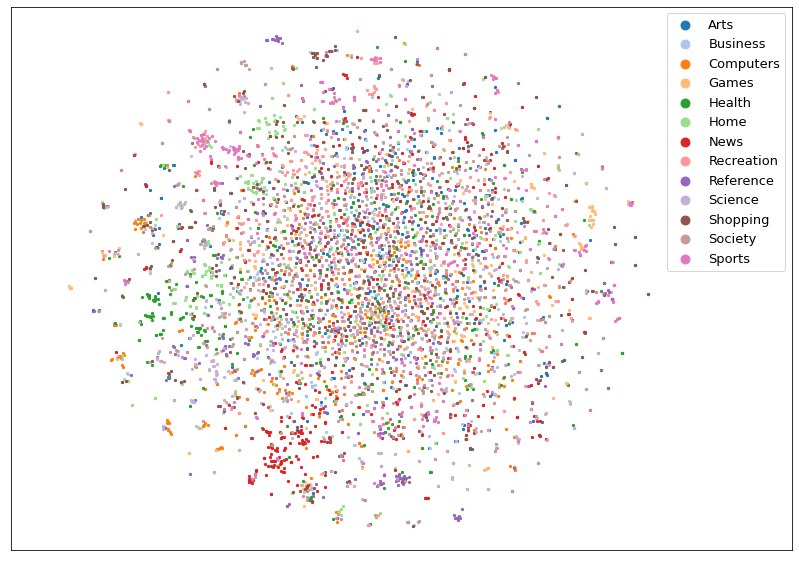

In [203]:
categories = df_valid.cat0.unique()

colormap = plt.get_cmap('tab20')

opacity = 1
marker_size = 5
marker = 'o'

fig, ax = plt.subplots(figsize=(14, 10))

n = 0
ncat = len(categories)

for cat in categories:
    ix = df_valid[df_valid.cat0 == cat].index
    x_val = x_tsne[ix][:,0]
    y_val = x_tsne[ix][:,1]
    plt.scatter(x_val, y_val, color=colormap(n), marker=marker, s=marker_size, alpha=opacity, label=cat)
    
    n += 1

ax.set_xlim([-80,100])
#ax.set_ylim([0,1])

ax.set_xticks([], [])
ax.set_yticks([], [])
    
#plt.title('t-SNE decomposition of description content in meta tags')
plt.legend(markerscale=4, fontsize=13)
plt.plot();

### Using classifier on XLM-R raw embedding

In [250]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

In [228]:
n_samples = 10_000

df_ml = df_en.groupby('cat0').sample(min(3696, n_samples), random_state=42)
df_ml['url_raw_emb'] = df_ml.apply(lambda row: xlmr.encode(row.clean_url), axis=1)

In [239]:
df_ml.url_raw_emb.notnull().value_counts()

True    48048
Name: url_raw_emb, dtype: int64

In [22]:
categories = df_ml.cat0.unique()

def categorize(c):
    return categories.tolist().index(c)

NameError: name 'df_ml' is not defined

In [242]:
df_ml['catno'] = df_ml.apply(lambda row: categorize(row.cat0), axis=1)

In [243]:
df_ml.head(1)

,uid,url,lang,lang_id,cat0,clean_url,ngrams,url_raw_emb,catno
673989,965931,www.donniemunro.co.uk,English,en,Arts,donniemunro,"[nniemun, mu, munr, iemu, nie, nn, munro, donn...","[0.15752316, -0.005854264, 0.27649218, 0.42970...",0


In [244]:
y = df_ml.catno.values
x = np.concatenate(df_ml.url_raw_emb.to_numpy()).ravel().reshape(-1, ndim)
x.shape

(48048, 768)

#### with SVM

In [292]:
clf = svm.LinearSVC(dual=False, C=10)

n_fold = 5
clf_scores = cross_validate(clf, x, y, cv=n_fold, scoring=['accuracy', 'precision_macro'], n_jobs=n_fold, return_train_score=True, verbose=True)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed: 14.2min remaining: 21.4min


KeyboardInterrupt: 

In [293]:
clf_scores

{'fit_time': array([383.19252181, 371.60759521, 390.38764668, 404.98861599,
        371.68509412]),
 'score_time': array([0.0365839 , 0.03690743, 0.04534459, 0.04789376, 0.03910279]),
 'test_accuracy': array([0.34994797, 0.34942768, 0.34672216, 0.35477157, 0.3576855 ]),
 'train_accuracy': array([0.40431344, 0.40106145, 0.40366304, 0.40201358, 0.40045267]),
 'test_precision_macro': array([0.34692452, 0.34676556, 0.34579536, 0.35267553, 0.35488378]),
 'train_precision_macro': array([0.40432668, 0.40023385, 0.4047198 , 0.40108099, 0.39972405])}

In [294]:
clf_scores['test_accuracy'].mean()

0.3517109772543495

#### with Random Forest

In [257]:
forest = RandomForestClassifier(n_estimators=300, max_depth=7, random_state=42)

n_fold = 5
forect_scores = cross_validate(forest, x, y, cv=n_fold, scoring=['accuracy', 'precision_macro'], n_jobs=n_fold, return_train_score=True, verbose=True)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  3.3min remaining:  5.0min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  3.4min finished


In [258]:
scores

{'fit_time': array([194.13378453, 194.28235173, 200.88547111, 198.16240954,
        193.03877854]),
 'score_time': array([0.79880524, 0.80038762, 0.62339878, 0.66720009, 0.61508441]),
 'test_accuracy': array([0.29167534, 0.29708637, 0.28699272, 0.29253825, 0.29545218]),
 'train_accuracy': array([0.41482387, 0.41089547, 0.40811176, 0.41174328, 0.41192539]),
 'test_precision_macro': array([0.30760587, 0.31197856, 0.3109369 , 0.30873414, 0.31638446]),
 'train_precision_macro': array([0.45850346, 0.4562197 , 0.45502432, 0.45629034, 0.45788426])}

In [259]:
scores['test_accuracy'].mean()

0.29274896962384267

## with several languages

In [259]:
lang = ['en', 'fr', 'de', 'it', 'es']

mask = df.lang_id.apply(lambda l: l in lang)
df_multi = df[mask]

In [260]:
df_multi_red = df_multi.groupby(['lang_id', 'cat0']).sample(100, random_state=42)

In [261]:
df_multi_red

,uid,url,lang,lang_id,cat0,clean_url
89738,1565121,sunnybastards.de,Deutsch,de,Arts,sunnybastards
89230,1505764,www.restaurierung-dietz.de,Deutsch,de,Arts,restaurierungdietz
83548,825664,www.drachenblaeser.de,Deutsch,de,Arts,drachenblaeser
89019,1477114,www.lichtkontrast.de,Deutsch,de,Arts,lichtkontrast
93755,2042530,www.ticket-to-dance.de,Deutsch,de,Arts,tickettodance
...,...,...,...,...,...,...
449383,912993,www.milanclubseregno.com,Italiano,it,Sports,milanclubseregno
449441,993993,www.fictoscana.it,Italiano,it,Sports,fictoscana
449675,1283979,www.toscana.federvolley.it,Italiano,it,Sports,toscana
450192,1856968,aps2003.altervista.org,Italiano,it,Sports,aps2003


it is better to tokenize on cleaned urls

In [344]:
tokenizer.tokenize('powerlifting-kamchatka')

['▁power', 'lifting', '-', 'kam', 'chat', 'ka']

In [345]:
tokenizer.tokenize('powerliftingkamchatka')

['▁power', 'lifting', 'kam', 'chat', 'ka']

In [453]:
df_multi_red['url_raw_emb'] = df_multi_red.apply(lambda row: xlmr.encode(row.clean_url), axis=1)

In [454]:
df_multi_red

,uid,url,lang,lang_id,cat0,clean_url,url_raw_emb
89738,1565121,sunnybastards.de,Deutsch,de,Arts,sunnybastards,"[0.07225161, 0.27825207, 0.18982054, -0.036904..."
89230,1505764,www.restaurierung-dietz.de,Deutsch,de,Arts,restaurierungdietz,"[-0.04095958, -0.010576029, 0.15705912, 0.0281..."
83548,825664,www.drachenblaeser.de,Deutsch,de,Arts,drachenblaeser,"[-0.084961094, 0.05472836, 0.16325842, -0.1086..."
89019,1477114,www.lichtkontrast.de,Deutsch,de,Arts,lichtkontrast,"[-0.0028609217, 0.37866613, 0.16153158, -0.117..."
93755,2042530,www.ticket-to-dance.de,Deutsch,de,Arts,tickettodance,"[0.03101627, -0.14746077, 0.09115102, 0.248388..."
...,...,...,...,...,...,...,...
449383,912993,www.milanclubseregno.com,Italiano,it,Sports,milanclubseregno,"[-0.0055238656, 0.032679327, 0.22239552, 0.070..."
449441,993993,www.fictoscana.it,Italiano,it,Sports,fictoscana,"[0.09711741, 0.16266365, 0.20569658, -0.068880..."
449675,1283979,www.toscana.federvolley.it,Italiano,it,Sports,toscana,"[0.08555452, -0.007927793, 0.22925249, 0.31219..."
450192,1856968,aps2003.altervista.org,Italiano,it,Sports,aps2003,"[0.03404619, 0.08483589, 0.28166857, 0.1057693..."


In [459]:
df_multi_red.reset_index(drop=True, inplace=True)

In [455]:
x = np.concatenate(df_multi_red.url_raw_emb.to_numpy()).ravel().reshape(-1, ndim)
x.shape

(6500, 768)

In [456]:
x_tsne = tsne.fit_transform(x)

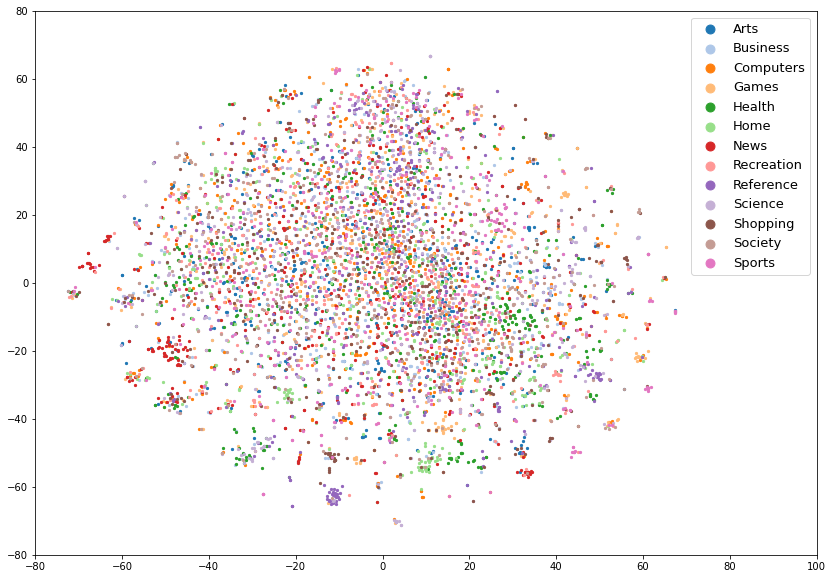

In [462]:
categories = df_valid.cat0.unique()

colormap = plt.get_cmap('tab20')

opacity = 1
marker_size = 5
marker = 'o'

fig, ax = plt.subplots(figsize=(14, 10))

n = 0
ncat = len(categories)

for cat in categories:
    ix = df_multi[df_multi.cat0 == cat].index
    x_val = x_tsne[ix][:,0]
    y_val = x_tsne[ix][:,1]
    plt.scatter(x_val, y_val, color=colormap(n), marker=marker, s=marker_size, alpha=opacity, label=cat)
    
    n += 1

ax.set_xlim([-80,100])
ax.set_ylim([-80,80])

#ax.set_xticks([], [])
#ax.set_yticks([], [])
    
#plt.title('t-SNE decomposition of description content in meta tags')
plt.legend(markerscale=4, fontsize=13)
plt.plot();

Maybe filtering with dictionnaries will gives better results

In [413]:
from unidecode import unidecode

In [414]:
filename = '/dlabdata1/lugeon/german_words.txt'
german_words = {}
with open(filename) as fh:
    for line in fh:
        word = unidecode(line.strip().split()[0])
        german_words[word] = None

In [415]:
filename = '/dlabdata1/lugeon/french_words.txt'
french_words = {}
with open(filename) as fh:
    for line in fh:
        word = unidecode(line.strip().split()[0])
        french_words[word] = None

In [446]:
filename = '/dlabdata1/lugeon/italian_words.txt'
italian_words = {}
with open(filename) as fh:
    for line in fh:
        word_ = line.strip().split()
        if len(word_) != 0:
            word = unidecode(word_[0])
            italian_words[word] = None

In [448]:
filename = '/dlabdata1/lugeon/spanish_words.txt'
spanish_words = {}
with open(filename) as fh:
    for line in fh:
        word = unidecode(line.strip().split()[0])
        spanish_words[word] = None

In [463]:
def get_word_embedding(word, lang):
    
    # clean from accents
    word = unidecode(word)
    
    # first look in english dictionnary, xlmr doesn't depend on the language
    emb_en = get_word_embedding_en(word)
    
    # if there is a match in english, or if the language is english, return result
    if (emb_en is not None) or (lang == 'en'):
        return emb_en
    
    # if not in english dictionnary, look in others dictionnaries
    words=None
    if(lang == 'fr'):
        words = french_words
    if(lang == 'de'):
        words = german_words    
    if(lang == 'it'):
        words = italian_words
    if(lang == 'es'):
        words = spanish_words
    
    # not a real word
    if word not in words:
        return None
    
    # it is a real word and the embedding is already computed
    if words[word] is None:
        emb = xlmr.encode(word)
        words[word] = emb
        return emb
    
    # it is a real word, but the embedding is not yet computed
    else:
        return words[word]

In [464]:
def get_url_embedding(url_ngrams, lang):
    acc = np.zeros(ndim)
    counter = 0
    for gram in url_ngrams:
        emb = get_word_embedding(gram, lang)
        if emb is not None:
            acc += emb
            counter += 1
            
    if counter == 0:
        return None
    else:
        return acc / counter

In [465]:
df_multi_red['ngrams'] = df_multi_red.apply(lambda row: concat_ngrams(row.clean_url, min_n=3, max_n=len(row.clean_url)), axis=1)

In [466]:
df_multi_red['url_dict_emb'] = df_multi_red.apply(lambda row: get_url_embedding(row.ngrams, row.lang_id), axis=1)

In [467]:
df_multi_red.head(1)

,uid,url,lang,lang_id,cat0,clean_url,url_raw_emb,ngrams,url_dict_emb
0,1565121,sunnybastards.de,Deutsch,de,Arts,sunnybastards,"[0.07225161, 0.27825207, 0.18982054, -0.036904...","[ybasta, nny, nnyb, unnyba, sunn, ast, tar, ba...","[0.08652209823152848, 0.00653021942291941, 0.2..."


In [468]:
df_multi_valid = df_multi_red[df_multi_red.url_dict_emb.notnull()]
df_multi_valid.reset_index(inplace=True, drop=True)
print('There is {:.2f}% of urls with real words'.format(df_multi_valid.shape[0] / df_multi.shape[0]))

There is 0.89% of urls with real words


In [469]:
x = np.concatenate(df_multi_valid.url_dict_emb.to_numpy()).ravel()
x = x.reshape(-1, ndim)
x.shape

(5762, 768)

In [470]:
tsne = TSNE(n_components=2)
x_tsne = tsne.fit_transform(x)

<ipython-input-471-e4be050f7f6f>:26: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_yticks([], [])


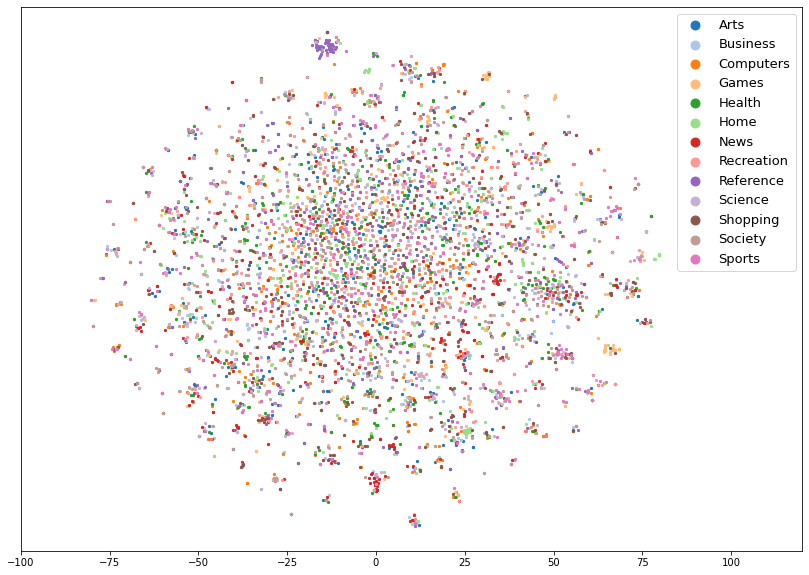

In [471]:
categories = df_multi_valid.cat0.unique()

colormap = plt.get_cmap('tab20')

opacity = 1
marker_size = 5
marker = 'o'

fig, ax = plt.subplots(figsize=(14, 10))

n = 0
ncat = len(categories)

for cat in categories:
    ix = df_multi_valid[df_multi_valid.cat0 == cat].index
    x_val = x_tsne[ix][:,0]
    y_val = x_tsne[ix][:,1]
    plt.scatter(x_val, y_val, color=colormap(n), marker=marker, s=marker_size, alpha=opacity, label=cat)
    
    n += 1

ax.set_xlim([-100,120])
#ax.set_ylim([0,1])

#ax.set_xticks([], [])
ax.set_yticks([], [])
    
#plt.title('t-SNE decomposition of description content in meta tags')
plt.legend(markerscale=4, fontsize=13)
plt.plot();

## Training a neural net on top on XLMR

### first with english only

In [50]:
df_en.cat0.value_counts()

Business      148144
Society        82079
Arts           66721
Shopping       54062
Recreation     46095
Computers      45194
Sports         34890
Science        28138
Health         24218
Reference      21663
Games          10246
Home            6952
News            3696
Name: cat0, dtype: int64

In [277]:
n_samples = 20_000
frac = 0.1

train, test = pd.DataFrame(), pd.DataFrame()

for cat in df_en.cat0.unique():
    df_cat = df_en[df_en.cat0 == cat]
    n = min(n_samples, df_cat.shape[0])
    df_cat = df_cat.sample(n, random_state=42)
    sep = int(n * frac)
    test = pd.concat((test, df_cat.iloc[:sep]))
    train = pd.concat((train, df_cat.iloc[sep:]))
    



In [278]:
train.shape, test.shape

((198806, 6), (22088, 6))

In [279]:
train['url_emb'] = [emb for emb in xlmr.encode(train.clean_url.values)]

In [280]:
test['url_emb'] = [emb for emb in xlmr.encode(test.clean_url.values)]

In [281]:
categories = train.cat0.unique()

def categorize(c):
    return categories.tolist().index(c)

In [282]:
train['catno'] = train.apply(lambda row: categorize(row.cat0), axis=1)
test['catno'] = test.apply(lambda row: categorize(row.cat0), axis=1)

In [283]:
train = train.sample(frac=1)
test = test.sample(frac=1)

In [284]:
train

,uid,url,lang,lang_id,cat0,clean_url,url_emb,catno
690283,1037371,www.babynamespedia.com,English,en,Home,babynamespedia,"[-0.11761432, -0.044715952, 0.24714959, -0.141...",12
586662,583330,compost.css.cornell.edu,English,en,Home,compost,"[0.11838444, 0.05656152, 0.21314698, -0.381394...",12
783409,1437229,www.cubaflags.com,English,en,Reference,cubaflags,"[-0.05752194, 0.23692326, 0.33617735, -0.03976...",6
984561,2312766,www.mah-jongg.ch,English,en,Games,mahjongg,"[-0.10451605, 0.041410238, 0.23232551, 0.21255...",10
726897,1197909,www.ghsol.com,English,en,Health,ghsol,"[0.11234024, -0.099976465, 0.39928335, -0.2876...",4
...,...,...,...,...,...,...,...,...
673757,964865,www.calgaryaikikai.com,English,en,Sports,calgaryaikikai,"[-0.10135986, 0.21500488, 0.21942918, 0.122488...",9
786197,1449104,s219981800.onlinehome.us,English,en,Shopping,s219981800,"[-0.04048866, 0.08143253, 0.13619147, -0.14607...",8
576244,536667,www.truebalticamber.com,English,en,Shopping,truebalticamber,"[-0.028945504, 0.32059136, 0.06777852, 0.30061...",8
867721,1802321,www.epalladio.com,English,en,Arts,epalladio,"[-0.035504147, 0.12258769, 0.18325253, -0.2187...",3


In [285]:
class_counts = train.catno.value_counts().sort_index()
class_counts

0     18000
1     18000
2     18000
3     18000
4     18000
5     18000
6     18000
7     18000
8     18000
9     18000
10     9222
11     3327
12     6257
Name: catno, dtype: int64

In [286]:
weights = class_counts.values / class_counts.values.sum()
weights = 1 / weights
weights = weights / weights.sum()
weights = weights * 13
weights

array([0.64232702, 0.64232702, 0.64232702, 0.64232702, 0.64232702,
       0.64232702, 0.64232702, 0.64232702, 0.64232702, 0.64232702,
       1.25372874, 3.47516875, 1.84783226])

In [287]:
from torch import nn
from torch.nn import functional as F
from torch import optim

In [288]:
class Embnet(nn.Module):
    def __init__(self):
        super(Embnet, self).__init__()

        self.fc1 = torch.nn.Linear(ndim, ndim)
        self.fc2 = torch.nn.Linear(ndim, ndim)
        self.fc3 = torch.nn.Linear(ndim, ndim)
        self.fc4 = torch.nn.Linear(ndim, 13)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(F.relu(x))
        x = self.fc3(F.relu(x))
        x = self.fc4(F.relu(x))
        return x
    

In [289]:
def accuracy(output, target):
    nb_samples = output.shape[0]
    
    # Convert probability to decision
    output_class = torch.argmax(output, 1)
    
    nb_correct = (output_class == target).sum().item()
    return nb_correct / nb_samples


In [290]:
train_input = np.concatenate(train.url_emb.to_numpy()).ravel().reshape(-1, ndim)
train_target = train.catno.values

test_input = np.concatenate(test.url_emb.to_numpy()).ravel().reshape(-1, ndim)
test_target = test.catno.values


In [291]:
train_input = torch.FloatTensor(train_input)
train_target = torch.LongTensor(train_target)
test_input = torch.FloatTensor(test_input)
test_target = torch.LongTensor(test_target)

In [292]:
train_input.shape, train_target.shape, test_input.shape, test_target.shape

(torch.Size([198806, 768]),
 torch.Size([198806]),
 torch.Size([22088, 768]),
 torch.Size([22088]))

In [293]:
epochs = 70
batch_size = 256

model = Embnet()
nb_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters: {}".format(nb_trainable_params))
# Loss
criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(weights))
#criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), 1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, eps=1e-8, patience=3, verbose=True)

#model.train(True)

for e in range(epochs):
    
    for input, target in zip(train_input.split(batch_size), train_target.split(batch_size)):
                             
        output = model(input)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        #model.train(False)
        train_output = model(train_input)
        test_output = model(test_input)
        train_loss = criterion(train_output, train_target)
        train_acc = accuracy(train_output, train_target)
        test_loss = criterion(test_output, test_target)
        test_acc = accuracy(test_output, test_target)
        print("Epoch {}".format(e) +\
              " | Train loss : {:.3f}".format(train_loss) +\
              " | Test loss : {:.3f}".format(test_loss) +\
              " | Train accuracy : {:.3f}".format(train_acc) +\
              " | Test accuracy : {:.3f}".format(test_acc))
        
    scheduler.step(test_acc)

Number of parameters: 1781773
Epoch 0 | Train loss : 2.028 | Test loss : 2.038 | Train accuracy : 0.325 | Test accuracy : 0.319
Epoch 1 | Train loss : 1.965 | Test loss : 1.988 | Train accuracy : 0.350 | Test accuracy : 0.340
Epoch 2 | Train loss : 1.915 | Test loss : 1.958 | Train accuracy : 0.366 | Test accuracy : 0.351
Epoch 3 | Train loss : 1.869 | Test loss : 1.936 | Train accuracy : 0.379 | Test accuracy : 0.361
Epoch 4 | Train loss : 1.824 | Test loss : 1.921 | Train accuracy : 0.391 | Test accuracy : 0.366
Epoch 5 | Train loss : 1.782 | Test loss : 1.910 | Train accuracy : 0.401 | Test accuracy : 0.371
Epoch 6 | Train loss : 1.741 | Test loss : 1.904 | Train accuracy : 0.411 | Test accuracy : 0.374
Epoch 7 | Train loss : 1.703 | Test loss : 1.904 | Train accuracy : 0.421 | Test accuracy : 0.375
Epoch 8 | Train loss : 1.668 | Test loss : 1.908 | Train accuracy : 0.429 | Test accuracy : 0.376
Epoch 9 | Train loss : 1.635 | Test loss : 1.917 | Train accuracy : 0.437 | Test accurac

### comparing with a Random Forest

In [157]:
forest = RandomForestClassifier(n_estimators=100, max_depth=7, random_state=42)
forest.fit(train_input.numpy(), train_target.numpy())

RandomForestClassifier(max_depth=7, random_state=42)

In [158]:
preds = forest.predict(test_input)
print('Accuracy: {:.3f}'.format((preds == test_target.numpy()).sum() / test_target.shape[0]))

Accuracy: 0.292


In [145]:
test_target.numpy()

array([5, 3, 2, ..., 1, 5, 7])

### multilingual with neural net

In [263]:
# the cat/lang with the least urls
df_multi.groupby(['lang', 'cat0']).uid.count().sort_values()[:10]

lang      cat0     
Español   Home          295
          News          300
Italiano  News          367
Français  News          531
Español   Sports        534
          Shopping      560
Italiano  Home          751
Español   Games         907
          Health        956
          Computers    1045
Name: uid, dtype: int64

In [264]:
n_samples = 5_000

frac = 0.1

train_m, test_m = pd.DataFrame(), pd.DataFrame()


for lang in df_multi.lang.unique():
    c = 0
    for cat in df_multi.cat0.unique():
        df_catlang = df_multi[(df_multi.cat0 == cat) & (df_multi.lang == lang)]
        n = min(n_samples, df_catlang.shape[0])
        df_catlang = df_catlang.sample(n, random_state=42)
        sep = int(n * frac)
        test_m = pd.concat((test_m, df_catlang.iloc[:sep]))
        train_m = pd.concat((train_m, df_catlang.iloc[sep:]))
        c += df_catlang.shape[0]
    print('{}: {} urls'.format(lang, c))

Deutsch: 55516 urls
Français: 44260 urls
Español: 19833 urls
Italiano: 29271 urls
English: 63696 urls


In [265]:
train_m.shape, test_m.shape

((191334, 6), (21242, 6))

In [266]:
train_m.cat0.value_counts()

Arts          21350
Society       20288
Business      19895
Recreation    17897
Computers     15264
Science       14991
Health        14796
Shopping      14105
Reference     13848
Sports        13337
Games         11156
Home           8485
News           5922
Name: cat0, dtype: int64

In [267]:
train_m['catno'] = train_m.apply(lambda row: categorize(row.cat0), axis=1)
test_m['catno'] = test_m.apply(lambda row: categorize(row.cat0), axis=1)

In [268]:
class_counts = train_m.catno.value_counts().sort_index()
weights = class_counts.values / class_counts.values.sum()
weights = 1 / weights
weights = weights / weights.sum()
weights = weights * 13
weights

array([0.85465344, 0.65571401, 0.64301213, 0.61102717, 0.88168628,
       0.87021747, 0.94204435, 0.72891714, 0.92487984, 0.97813827,
       1.16936448, 2.20287574, 1.53746967])

In [269]:
train_m['url_emb'] = [emb for emb in xlmr.encode(train_m.clean_url.values)]

In [270]:
test_m['url_emb'] = [emb for emb in xlmr.encode(test_m.clean_url.values)]

In [271]:
train_m_input = np.concatenate(train_m.url_emb.to_numpy()).ravel().reshape(-1, ndim)
train_m_target = train_m.catno.values

test_m_input = np.concatenate(test_m.url_emb.to_numpy()).ravel().reshape(-1, ndim)
test_m_target = test_m.catno.values

In [272]:
train_input = torch.FloatTensor(train_input)
train_target = torch.LongTensor(train_target)
test_input = torch.FloatTensor(test_input)
test_target = torch.LongTensor(test_target)

In [274]:
epochs = 70
batch_size = 256

model = Embnet()
nb_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters: {}".format(nb_trainable_params))
# Loss
criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(weights))
#criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), 1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, eps=1e-8, patience=3, verbose=True)

#model.train(True)

for e in range(epochs):
    
    for input, target in zip(train_input.split(batch_size), train_target.split(batch_size)):
                             
        output = model(input)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        #model.train(False)
        train_output = model(train_input)
        test_output = model(test_input)
        train_loss = criterion(train_output, train_target)
        train_acc = accuracy(train_output, train_target)
        test_loss = criterion(test_output, test_target)
        test_acc = accuracy(test_output, test_target)
        print("Epoch {}".format(e) +\
              " | Train loss : {:.3f}".format(train_loss) +\
              " | Test loss : {:.3f}".format(test_loss) +\
              " | Train accuracy : {:.3f}".format(train_acc) +\
              " | Test accuracy : {:.3f}".format(test_acc))
        
    scheduler.step(test_acc)

Number of parameters: 1781773
Epoch 0 | Train loss : 1.932 | Test loss : 1.949 | Train accuracy : 0.360 | Test accuracy : 0.354
Epoch 1 | Train loss : 1.864 | Test loss : 1.897 | Train accuracy : 0.382 | Test accuracy : 0.372
Epoch 2 | Train loss : 1.811 | Test loss : 1.864 | Train accuracy : 0.399 | Test accuracy : 0.383
Epoch 3 | Train loss : 1.767 | Test loss : 1.841 | Train accuracy : 0.414 | Test accuracy : 0.392
Epoch 4 | Train loss : 1.728 | Test loss : 1.826 | Train accuracy : 0.426 | Test accuracy : 0.396
Epoch 5 | Train loss : 1.694 | Test loss : 1.816 | Train accuracy : 0.437 | Test accuracy : 0.402
Epoch 6 | Train loss : 1.663 | Test loss : 1.811 | Train accuracy : 0.445 | Test accuracy : 0.402
Epoch 7 | Train loss : 1.635 | Test loss : 1.810 | Train accuracy : 0.453 | Test accuracy : 0.405
Epoch 8 | Train loss : 1.609 | Test loss : 1.812 | Train accuracy : 0.461 | Test accuracy : 0.406
Epoch 9 | Train loss : 1.584 | Test loss : 1.815 | Train accuracy : 0.469 | Test accurac

KeyboardInterrupt: 